# Consolidate all Preprocessing Functions

Possibly generalize all functions by including them into one class or multiple functions. Doesn't have to be pretty because we just want the finalized `vector_stores`.

In [17]:
"""
import packages:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import deeplake
from torchvision import transforms, models, datasets
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image
import torchvision
import flask
from deeplake.core.vectorstore.deeplake_vectorstore import VectorStore
import os
import torch
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image, ImageFilter
import shutil
import imageio.v2 as imageio
import multiprocess as mp
from tqdm import tqdm

## Image Preprocessing Functions

### Edge Detection

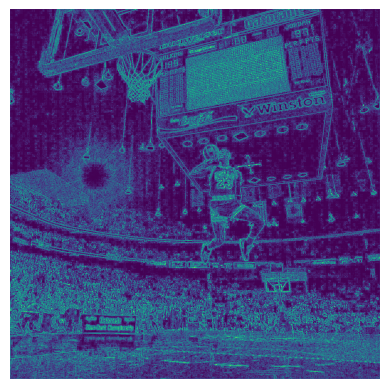

In [13]:
"""
***KEEP THESE SEPARATE I THINK***
Preprocessing functions:
- edge detect function
- 
"""

def edge_detect(image_path):
    
    #load image from path
    image = Image.open(image_path)
    #convert to greyscale as edge detection needs greyscale
    image = image.convert('L')
    #detect edges
    image = image.filter(ImageFilter.FIND_EDGES)

    return image, image_path ## Why are we returning the path?

jordan_path = '../data/test-images/jordan.jpg'
jordan_edge, jordan_edge_path = edge_detect(jordan_path)

plt.imshow(jordan_edge)
plt.axis('off')
plt.show()

*We should be multiprocessing to take in one image path and output all of the vector stores; not sure this function is needed*

In [4]:
"""
Three vector store preprocessing as far as I know: 
- normal vector store
- grey-scaled vector store
- edge detected vector store

Keep processing functions separate because they are needed for test images too.
"""

def edge_preprocess(edge_image_path, images_paths):
    
    #get cpu count:
    cpu_count = mp.cpu_count()

    #make pool of workers
    pool = mp.Pool(processes=cpu_count)

    #parallel preprocess and save into edge_image folder
    for edge_img, path in pool.starmap(edge_detect, [(path,) for path in images_paths]):
        plt.imsave(f'{edge_image_path}/{os.path.basename(path)}', edge_img)

    #close pool of workers
    pool.close()
    pool.join()
    




### Subject Segmentation

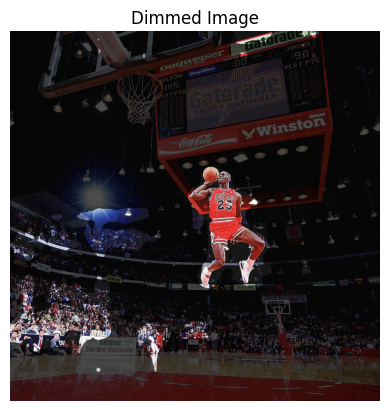

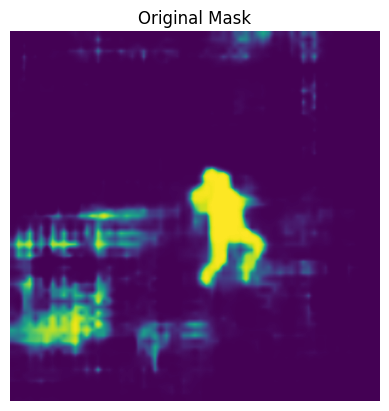

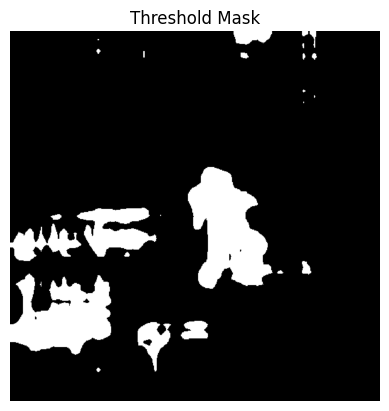

In [10]:
def person_highlighter(image_path, threshold=0.5, dimming_factor=0.3, all_images=False):
    img = Image.open(image_path)
    image_copy = img.copy()
    x = torchvision.transforms.functional.to_tensor(img)

    # Load weights
    weights = FCN_ResNet50_Weights.DEFAULT
    model = fcn_resnet50(weights=weights, pretrained=True)

    # Set the model to evaluation mode
    preprocess = weights.transforms()

    batch = preprocess(x).unsqueeze(0)

    # Perform inference
    prediction = model(batch)["out"]
    normalized_masks = prediction.softmax(dim=1)

    class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
    original_mask = normalized_masks[0, class_to_idx["person"]]

    # Add zeroes to the mask so it's the same size as the image
    mask = (
        torch.nn.functional.interpolate(
            original_mask.unsqueeze(0).unsqueeze(0),
            size=(img.height, img.width),
            mode="nearest",
        )
        .squeeze(0)
        .squeeze(0)
    )

    # Convert the mask to a numpy array
    mask = mask.detach().numpy()

    person_mask = mask > threshold

    dimmed_img = image_copy.copy()

    # Make dimmed img the same size as the person mask
    dimmed_img = np.array(img)

    # Multiply the dimmed image by the mask

    # This is much faster but struggles with certain sized photos
    try:
        dimmed_img[~person_mask] = dimmed_img[~person_mask] * dimming_factor

    # This is slower but works for all photos
    except IndexError:

        for y in range(img.size[1]):
            for x in range(img.size[0]):
                if not person_mask[y, x]:
                    dimmed_img[y, x] = dimmed_img[y, x] * dimming_factor

    # If all images, Return threshold mask, mask, and dimmed image
    if all_images:
        return (
            to_pil_image(original_mask),
            Image.fromarray(person_mask),
            Image.fromarray(dimmed_img),
        )

    # Return only the dimmed image
    else:
        return Image.fromarray(dimmed_img)
    

# Test the function
original_mask, threshold_mask, dimmed_img = person_highlighter(
    jordan_path, threshold=0.2, dimming_factor=0.3, all_images=True # We need to establish a threshold and dimming factor
)

plt.imshow(dimmed_img)
plt.title("Dimmed Image")
plt.axis("off")
plt.show()

plt.imshow(original_mask)
plt.title("Original Mask")
plt.axis("off")
plt.show()

plt.imshow(threshold_mask)
plt.title("Threshold Mask")
plt.axis("off")
plt.show()

In [16]:
"""
Create ResNet34 model
(COULD BE PART OF A CLASS)
""" 
def resnet():
    # Check if GPU is available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Load the model
    model = models.resnet34(pretrained=True)

    # Create a feature extractor
    return_nodes = {
        'avgpool': 'embedding'
    }
    model = create_feature_extractor(model, return_nodes=return_nodes)

    # Freeze the model
    model.eval()
    model.to(device)
    return model

In [18]:
"""
Embedding Function
(COULD BE PART OF A CLASS)
"""
def embedding_function(images, model, device, batch_size = 4):
    """Creates a list of embeddings based on a list of image filenames. Images are processed in batches."""
    transform= transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.cat([x, x, x], dim=0) if x.shape[0] == 1 else x),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    if isinstance(images, str):
        images = [images]

    # Proceess the embeddings in batches, but return everything as a single list
    embeddings = []
    for i in range(0, len(images), batch_size):
        batch = torch.stack([transform(Image.open(item)) for item in images[i:i+batch_size]])
        batch = batch.to(device)
        with torch.no_grad():
            embeddings+= model(batch)['embedding'][:,:,0,0].cpu().numpy().tolist()

    return embeddings

## Preprocess all Images

In [ ]:
# Create output folders
def create_image_output_dirs(output_path="../data/"):
    # Create output paths
    edge_path = os.path.join(output_path, "edge/")
    dimmed_path = os.path.join(output_path, "dimmed/")
    threshold_path = os.path.join(output_path, "threshold/")
    mask_path = os.path.join(output_path, "mask/")
    segmeneted_edge_path = os.path.join(output_path, "segmented_edge/")

    # Create the directories
    os.makedirs(edge_path, exist_ok=True)
    os.makedirs(dimmed_path, exist_ok=True)
    os.makedirs(threshold_path, exist_ok=True)
    os.makedirs(mask_path, exist_ok=True)
    os.makedirs(segmeneted_edge_path, exist_ok=True)

    return None


# Test the function
create_image_output_dirs()

In [21]:
def process_image(image_path, threshold, dimming_factor, output_path="../data/"):
    # Create subject segmentation
    full_mask, threshold_mask, dimmed_img = person_highlighter(
        image_path,
        threshold=threshold,
        dimming_factor=dimming_factor,
        all_images=True,  # We need to establish a threshold and dimming factor
    )

    # Create edge detection
    edge_img, edge_img_path = edge_detect(image_path) # Remove path from return if we want

    # Create segmented edge detection
    # Make dimmed img the same size as the person mask
    dimmed_edge = np.array(edge_img)
    threshold_array = np.array(threshold_mask)

    # Multiply the dimmed image by the mask

    # This is much faster but struggles with certain sized photos
    try:
        dimmed_edge[~threshold_array] = dimmed_edge[~threshold_array] * dimming_factor

    # This is slower but works for all photos
    except IndexError:

        for y in range(dimmed_edge.size[1]):
            for x in range(dimmed_edge.size[0]):
                if not dimmed_edge[y, x]:
                    dimmed_edge[y, x] = dimmed_edge[y, x] * dimming_factor

    # Convert the dimmed edge to an image
    dimmed_edge = Image.fromarray(dimmed_edge)

    # Write the images to disk

    # Create output paths
    edge_path = os.path.join(output_path, "edge/")
    dimmed_path = os.path.join(output_path, "dimmed/")
    threshold_path = os.path.join(output_path, "threshold/")
    mask_path = os.path.join(output_path, "mask/")
    segmeneted_edge_path = os.path.join(output_path, "segmented_edge/")

    image_name = os.path.basename(image_path)

    # Save the images
    edge_img.save(edge_path + image_name)
    dimmed_img.save(dimmed_path + image_name)
    threshold_mask.save(threshold_path + image_name)
    full_mask.save(mask_path + image_name)
    dimmed_edge.save(segmeneted_edge_path + image_name)

    # Function has no return value
    return None

# Test the function

# Select 100 images
images = [f"../data/raw/{item}" for item in os.listdir("../data/raw/")[:100]]

# Process the images
for img in tqdm(images):
    process_image(img, threshold=0.1, dimming_factor=0.3)
    

100%|██████████| 100/100 [07:53<00:00,  4.73s/it]


In [31]:
# Print average time per image
avg_time = round(((7*60 + 53)/100), 4) # Change math to reflect actual time
print("Average time per image: ", avg_time, " seconds per image")
print("Time it would take to process all images on one CPU:", round((avg_time*len(os.listdir('../data/raw'))/60) / 60, 2), " hours")
print("Time it would take to process all images on 6 CPU:", round((avg_time*len(os.listdir('../data/raw'))/60) / 60 / 6, 2), " hours")

Average time per image:  4.73  seconds per image
Time it would take to process all images on one CPU: 100.66  hours
Time it would take to process all images on 6 CPU: 16.78  hours


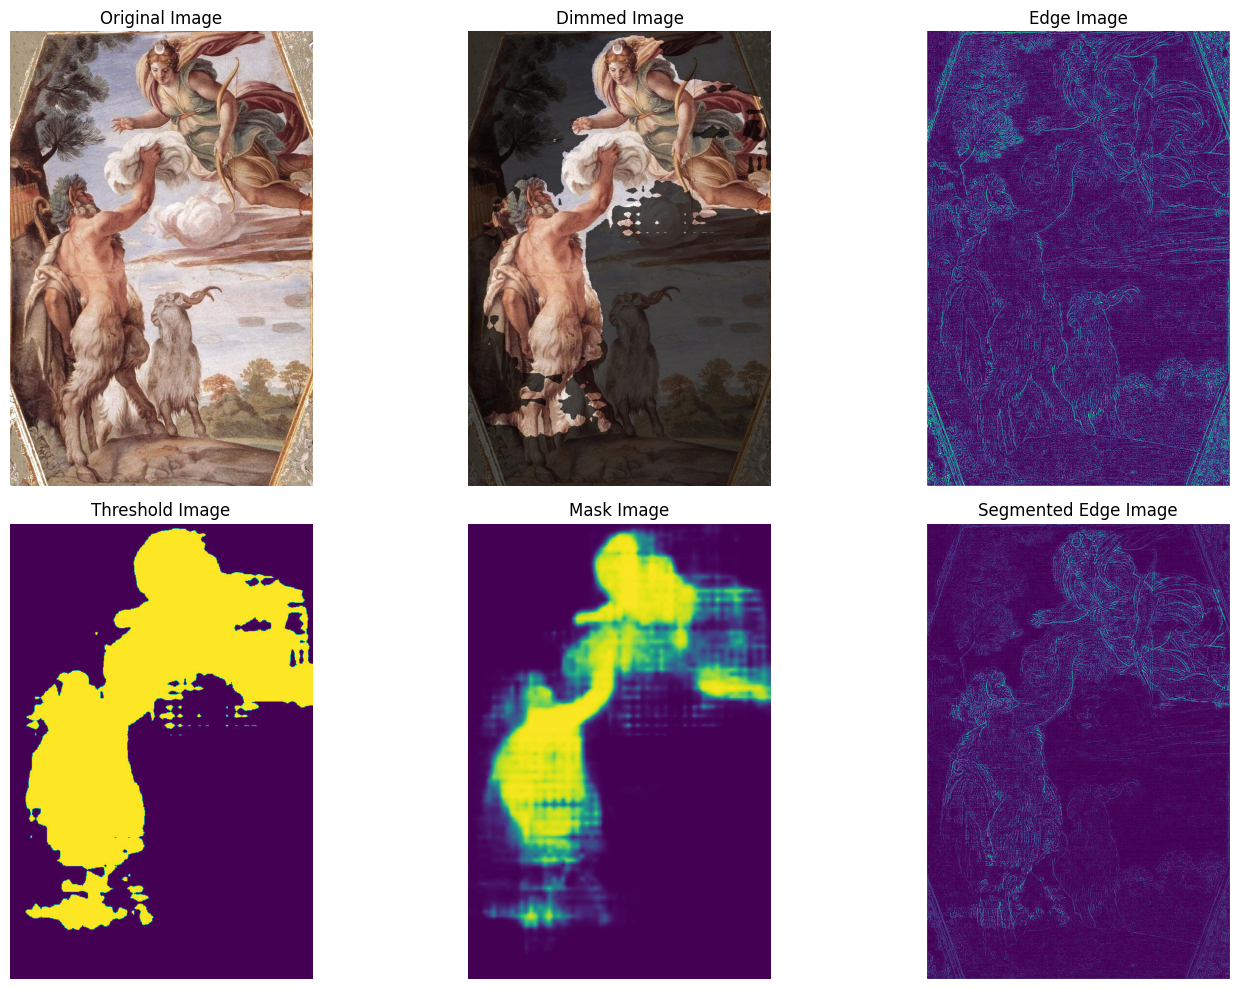

In [23]:
# Show all the outputs for one image
image_name = "style_baroque_index_7673.jpg"

# Load the images
original_img = Image.open(f"../data/raw/{image_name}")
edge_img = Image.open(f"../data/edge/{image_name}")
dimmed_img = Image.open(f"../data/dimmed/{image_name}")
threshold_img = Image.open(f"../data/threshold/{image_name}")
mask_img = Image.open(f"../data/mask/{image_name}")
segmented_edge_img = Image.open(f"../data/segmented_edge/{image_name}")

# Plot the images
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the original image
axs[0, 0].imshow(original_img)
axs[0, 0].set_title("Original Image")
axs[0, 0].axis("off")

# Plot the dimmed image
axs[0, 1].imshow(dimmed_img)
axs[0, 1].set_title("Dimmed Image")
axs[0, 1].axis("off")

# Plot the edge image
axs[0, 2].imshow(edge_img)
axs[0, 2].set_title("Edge Image")
axs[0, 2].axis("off")

# Plot the threshold image
axs[1, 0].imshow(threshold_img)
axs[1, 0].set_title("Threshold Image")
axs[1, 0].axis("off")

# Plot the mask image
axs[1, 1].imshow(mask_img)
axs[1, 1].set_title("Mask Image")
axs[1, 1].axis("off")

# Plot the segmented edge image
axs[1, 2].imshow(segmented_edge_img)
axs[1, 2].set_title("Segmented Edge Image")
axs[1, 2].axis("off")

plt.tight_layout()
plt.show()

## Create Vector Stores

- Vector Store Folder Containing All Vector Stores
- Original Images
- Dimmed Images
- Edge Detected Images
- Threshold Masks 
- Subject Segmented Images
- Dimmed Images + Subject Segmented Images

In [14]:
"""
Create vector store function?
(COULD BE PART OF A CLASS)
"""
def make_vector_store_dir():
    print("Loading Model")
    model = resnet()
    print("Model Loaded")
    
    # Check if Vector Stores Folder exists
    if os.path.exits('vector_stores'):
        shutil.rmtree('vector_stores')

    # If not, create it
    else:
        os.makedirs('vector_stores')

    print("Creating Vector Stores")

    # Path to the individual vector stores
    raw_vs = VectorStore('vector_stores/raw_vs')
    edge_vs = VectorStore('vector_stores/edge_vs')
    dimmed_vs = VectorStore('vector_stores/dimmed_vs')




In [ ]:
from deeplake.core.vectorstore.deeplake_vectorstore import VectorStore


def create_all_vector_stores(vector_store_path="vector_stores"):
    print("Loading Model")
    model = resnet()
    print("Model Loaded")

    # Check if Vector Stores Folder exists
    if os.path.exists(vector_store_path):
        shutil.rmtree(vector_store_path)

    # If not, create it
    else:
        os.makedirs(vector_store_path)

    print("Creating Vector Stores")
    # Path to the individual vector stores
    raw_vs = VectorStore(
        path=f"{vector_store_path}/raw_vs",
        tensor_params=[
            {"name": "image", "htype": "image", "sample_compression": "jpg"},
            {"name": "embedding", "htype": "embedding"},
            {"name": "filename", "htype": "text"},
        ],
    )
    edge_vs = VectorStore(
        path=f"{vector_store_path}/edge_vs",
        tensor_params=[
            {"name": "image", "htype": "image", "sample_compression": "jpg"},
            {"name": "embedding", "htype": "embedding"},
            {"name": "filename", "htype": "text"},
        ],
    )
    dimmed_vs = VectorStore(
        path=f"{vector_store_path}/dimmed_vs",
        tensor_params=[
            {"name": "image", "htype": "image", "sample_compression": "jpg"},
            {"name": "embedding", "htype": "embedding"},
            {"name": "filename", "htype": "text"},
        ],
    )
    threshold_vs = VectorStore(
        path=f"{vector_store_path}/threshold_vs",
        tensor_params=[
            {"name": "image", "htype": "image", "sample_compression": "jpg"},
            {"name": "embedding", "htype": "embedding"},
            {"name": "filename", "htype": "text"},
        ],
    )
    mask_vs = VectorStore(
        path=f"{vector_store_path}/mask_vs",
        tensor_params=[
            {"name": "image", "htype": "image", "sample_compression": "jpg"},
            {"name": "embedding", "htype": "embedding"},
            {"name": "filename", "htype": "text"},
        ],
    )
    segmented_edge_vs = VectorStore(
        path=f"{vector_store_path}/segmented_edge_vs",
        tensor_params=[
            {"name": "image", "htype": "image", "sample_compression": "jpg"},
            {"name": "embedding", "htype": "embedding"},
            {"name": "filename", "htype": "text"},
        ],
    )
    print("Vector Stores Created")

    # Get the list of images
    raw_images = [f"../data/raw/{item}" for item in os.listdir("../data/raw/")]
    edge_images = [f"../data/edge/{item}" for item in os.listdir("../data/edge/")]
    dimmed_images = [f"../data/dimmed/{item}" for item in os.listdir("../data/dimmed/")]
    threshold_images = [f"../data/threshold/{item}" for item in os.listdir("../data/threshold/")]
    mask_images = [f"../data/mask/{item}" for item in os.listdir("../data/mask/")]
    segmented_edge_images = [f"../data/segmented_edge/{item}" for item in os.listdir("../data/segmented_edge/")]

    print("Adding Images to Vector Stores")
    # Add the images to the vector stores
    print("Raw Images")
    raw_vs.add(image = raw_images,
                 filename = raw_images,
                 embedding_function = embedding_function, 
                 embedding_data = raw_images)
    
    print("Edge Images")
    edge_vs.add(image = edge_images,
                 filename = edge_images,
                 embedding_function = embedding_function, 
                 embedding_data = edge_images)
    
    print("Dimmed Images")
    dimmed_vs.add(image = dimmed_images,
                 filename = dimmed_images,
                 embedding_function = embedding_function, 
                 embedding_data = dimmed_images)
    
    print("Threshold Images")
    threshold_vs.add(image = threshold_images,
                 filename = threshold_images,
                 embedding_function = embedding_function, 
                 embedding_data = threshold_images)
    
    print("Mask Images")
    mask_vs.add(image = mask_images,
                 filename = mask_images,
                 embedding_function = embedding_function, 
                 embedding_data = mask_images)
    
    print("Segmented Edge Images")
    segmented_edge_vs.add(image = segmented_edge_images,
                 filename = segmented_edge_images,
                 embedding_function = embedding_function, 
                 embedding_data = segmented_edge_images)
    
    print("Images Successfully Added to Vector Stores")
    return None

In [ ]:
"""
Get image paths for image embedding later
(COULD BE PART OF A CLASS)
"""

In [ ]:
"""
Add to vector store
(COULD BE PART OF A CLASS)
"""

In [ ]:
"""
Get test images
(COULD BE PART OF A CLASS)
"""

In [ ]:
"""
Show results
(COULD BE PART OF A CLASS)
"""